In [ ]:
library(dplyr)
library(vcdExtra)
library(mice)
library(caret)
library(AUC)
library(ROSE)
library("caret")
library(ggplot2)
library(fbroc)
library(Hmisc)

df <- read.csv('CARS.csv')
df$Invoice <- as.numeric(gsub("[$,]", "", df$Invoice))
df$MSRP <- as.numeric(gsub("[$,]", "", df$Invoice))

In [ ]:
df$Cheap <- df$Invoice < 20000

### Пункт 1

В качестве основного предиктора рассмотрим бинарную переменную Wheelbase_bin (длинная или короткая колесная база)

In [ ]:
copy_df <- df
copy_df$Wheelbase_bin <- ifelse(copy_df$Wheelbase > median(copy_df$Wheelbase), 'Long', 'Short')
table_chi <- table(copy_df$Wheelbase_bin, copy_df$Cheap)
chisq.test(table_chi)


	Pearson's Chi-squared test with Yates' continuity correction

data:  table_chi
X-squared = 54.893, df = 1, p-value = 1.273e-13


p-value < 0.05, значит, зависимость статистически значима. Теперь добавим стратифицирующий предиктор Horsepower_bin (маломощные и высокомощные автомобили)

In [ ]:
# тест CMH

copy_df$Horsepower_bin <- ifelse(copy_df$Horsepower > median(copy_df$Horsepower), 'HighPower', 'LowPower')
CMHtest(Cheap ~ Wheelbase_bin | Horsepower_bin, data = copy_df)

$`Horsepower_bin:HighPower`
Cochran-Mantel-Haenszel Statistics for Wheelbase_bin by Cheap 
	in stratum Horsepower_bin:HighPower 

                 AltHypothesis    Chisq Df    Prob
cor        Nonzero correlation 0.019933  1 0.88772
rmeans  Row mean scores differ 0.019933  1 0.88772
cmeans  Col mean scores differ 0.019933  1 0.88772
general    General association 0.019933  1 0.88772


$`Horsepower_bin:LowPower`
Cochran-Mantel-Haenszel Statistics for Wheelbase_bin by Cheap 
	in stratum Horsepower_bin:LowPower 

                 AltHypothesis Chisq Df       Prob
cor        Nonzero correlation 21.45  1 3.6311e-06
rmeans  Row mean scores differ 21.45  1 3.6311e-06
cmeans  Col mean scores differ 21.45  1 3.6311e-06
general    General association 21.45  1 3.6311e-06



Полученные значения p-value > 0.05 для высокомощных автомобилей, и p-value < 0.05 для маломощных. Таким образом, статистически значимой связи между Cheap и Wheelbase_bin для высокомощных автомобилей не наблюдается

## Пункт 2

Заполним пропуски

In [ ]:
imputed_data <- mice(df, m = 5, maxit = 5, method = "pmm", seed = 42)
completed_data <- complete(imputed_data, 1)
df <- completed_data


 iter imp variable
  1   1  Cylinders
  1   2  Cylinders
  1   3  Cylinders
  1   4  Cylinders
  1   5  Cylinders
  2   1  Cylinders
  2   2  Cylinders
  2   3  Cylinders
  2   4  Cylinders
  2   5  Cylinders
  3   1  Cylinders
  3   2  Cylinders
  3   3  Cylinders
  3   4  Cylinders
  3   5  Cylinders
  4   1  Cylinders
  4   2  Cylinders
  4   3  Cylinders
  4   4  Cylinders
  4   5  Cylinders
  5   1  Cylinders
  5   2  Cylinders
  5   3  Cylinders
  5   4  Cylinders
  5   5  Cylinders


Warning message:
“Number of logged events: 6”


In [ ]:
df$Origin <- as.factor(df$Origin)
df$Type <- as.factor(df$Type)
df$Make <- as.factor(df$Make)
df$Model <- as.factor(df$Model)
df$DriveTrain <- as.factor(df$DriveTrain)
df$Cheap <- as.factor(df$Cheap)

# effect схема кодирования

contrasts(df$Origin) <- contr.sum(levels(df$Origin))
contrasts(df$Type) <- contr.sum(levels(df$Type))
contrasts(df$Make) <- contr.sum(levels(df$Make))
contrasts(df$Model) <- contr.sum(levels(df$Model))
contrasts(df$DriveTrain) <- contr.sum(levels(df$DriveTrain))
contrasts(df$Cheap) <- contr.sum(levels(df$Cheap))

In [ ]:
base_model <- glm(Cheap ~ 1, data = df, family = binomial(link="logit"))
forward <- step(base_model, scope = list(lower = base_model, upper = Cheap ~ Origin + Type + Make + Model + DriveTrain + EngineSize + Cylinders + Horsepower + MPG_City + MPG_Highway + Weight + Wheelbase + Length), trace = TRUE, direction = 'forward')

Start:  AIC=517.23
Cheap ~ 1



Warning message:
“glm.fit: algorithm did not converge”


               Df Deviance    AIC
+ Horsepower    1   213.22 217.22
+ MPG_City      1   305.63 309.63
+ Cylinders     1   327.94 331.94
+ Weight        1   336.24 340.24
+ EngineSize    1   352.43 356.43
+ MPG_Highway   1   378.17 382.17
+ Make         37   315.22 391.22
+ Wheelbase     1   452.34 456.34
+ Origin        2   451.27 457.27
+ Length        1   459.46 463.46
+ DriveTrain    2   460.59 466.59
+ Type          5   479.56 491.56
<none>              515.23 517.23
+ Model       424     0.00 850.00

Step:  AIC=217.22
Cheap ~ Horsepower



Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message:
“glm.fit: algorithm did not converge”


               Df Deviance    AIC
+ Type          5   180.30 194.30
+ Origin        2   191.70 199.70
+ EngineSize    1   208.93 214.93
+ Wheelbase     1   210.16 216.16
+ MPG_Highway   1   211.12 217.12
<none>              213.22 217.22
+ Length        1   211.24 217.23
+ Weight        1   213.17 219.17
+ Cylinders     1   213.22 219.22
+ MPG_City      1   213.22 219.22
+ DriveTrain    2   212.54 220.54
+ Make         37   151.57 229.58
+ Model       423     0.00 850.00

Step:  AIC=194.3
Cheap ~ Horsepower + Type



Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message:
“glm.fit: algorithm did not converge”


               Df Deviance    AIC
+ Origin        2   165.04 183.04
+ MPG_City      1   173.04 189.04
+ Weight        1   173.98 189.98
+ DriveTrain    2   173.84 191.84
+ MPG_Highway   1   177.40 193.40
+ Wheelbase     1   177.71 193.71
<none>              180.30 194.30
+ Length        1   179.74 195.74
+ Cylinders     1   179.88 195.88
+ EngineSize    1   180.30 196.30
+ Make         37   131.22 219.22
+ Model       418     0.00 850.00

Step:  AIC=183.04
Cheap ~ Horsepower + Type + Origin



Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message:
“glm.fit: algorithm did not converge”


               Df Deviance    AIC
+ DriveTrain    2   156.23 178.23
+ MPG_City      1   158.52 178.52
+ Weight        1   158.87 178.87
+ Wheelbase     1   160.32 180.32
+ Length        1   160.39 180.39
+ MPG_Highway   1   161.54 181.54
<none>              165.04 183.04
+ EngineSize    1   163.39 183.39
+ Cylinders     1   164.81 184.81
+ Make         35   131.22 219.22
+ Model       416     0.00 850.00

Step:  AIC=178.23
Cheap ~ Horsepower + Type + Origin + DriveTrain



Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message:
“glm.fit: algorithm did not converge”


               Df Deviance    AIC
+ Wheelbase     1   149.46 173.46
+ Length        1   149.70 173.70
+ Weight        1   151.24 175.23
+ MPG_City      1   151.64 175.64
<none>              156.23 178.23
+ MPG_Highway   1   154.36 178.36
+ EngineSize    1   154.88 178.88
+ Cylinders     1   155.12 179.12
+ Make         35   126.82 218.82
+ Model       415     0.00 852.00

Step:  AIC=173.46
Cheap ~ Horsepower + Type + Origin + DriveTrain + Wheelbase



Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message:
“glm.fit: algorithm did not converge”


               Df Deviance    AIC
<none>              149.46 173.46
+ MPG_City      1   147.96 173.96
+ Length        1   148.75 174.75
+ Weight        1   148.82 174.82
+ MPG_Highway   1   149.08 175.08
+ EngineSize    1   149.35 175.35
+ Cylinders     1   149.39 175.39
+ Make         35   119.63 213.63
+ Model       414     0.00 852.00


Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message:
“contrasts dropped from factor Type”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message:
“contrasts dropped from factor Type”
Warning message:
“contrasts dropped from factor Origin”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message:
“contrasts dropped from factor Type”
Warning message:
“contrasts dropped from factor Origin”
Warning message:
“contrasts dropped from factor DriveTrain”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message:
“contrasts dropped from factor Type”
Warning message:
“contrasts dropped from factor Origin”
Warning message:
“contrasts dropped from factor DriveTrain”


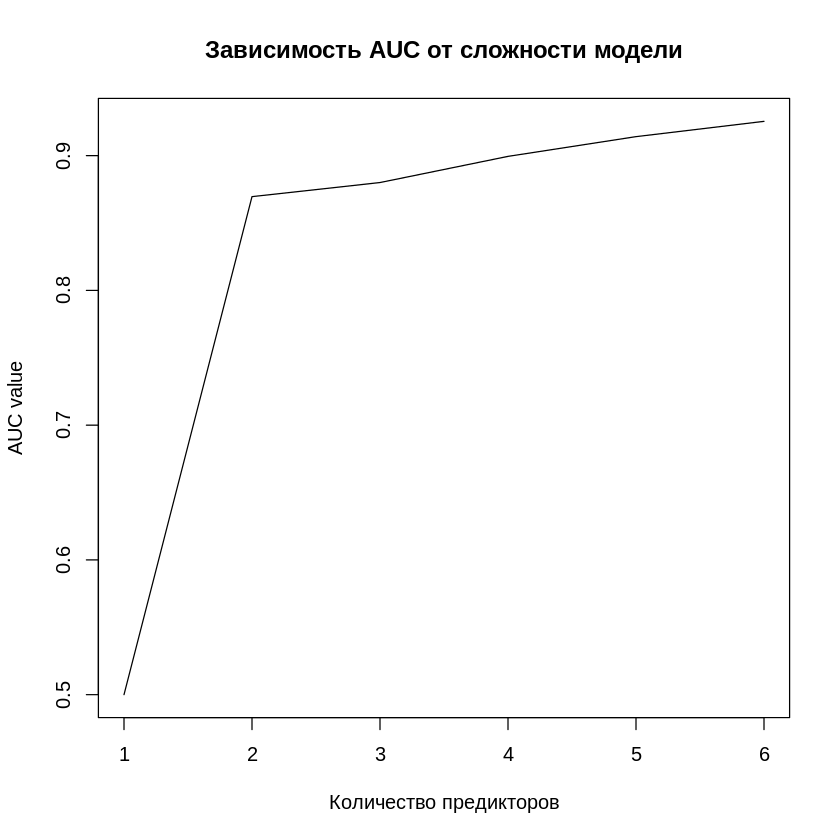

In [ ]:
df$true_col <- TRUE
auc_values <- c()

train_control <- trainControl(method = "cv")
model <- train(Cheap ~ true_col, data = df, method = "glm", family = binomial(link="logit"))
pred <- predict(model, newdata = df)
auc_values <- append(auc_values, auc(roc(pred,df$Cheap)))

train_control <- trainControl(method = "cv", number = 5)
model <- train(Cheap ~ Horsepower, data = df, method = "glm", family = binomial(link="logit"), trControl = train_control)
pred <- predict(model, newdata = df)
auc_values <- append(auc_values, auc(roc(pred,df$Cheap)))

train_control <- trainControl(method = "cv", number = 5)
model <- train(Cheap ~ Horsepower + Type, data = df, method = "glm", family = binomial(link="logit"), trControl = train_control)
pred <- predict(model, newdata = df)
auc_values <- append(auc_values, auc(roc(pred,df$Cheap)))

train_control <- trainControl(method = "cv", number = 5)
model <- train(Cheap ~ Horsepower + Type + Origin, data = df, method = "glm", family = binomial(link="logit"), trControl = train_control)
pred <- predict(model, newdata = df)
auc_values <- append(auc_values, auc(roc(pred,df$Cheap)))

train_control <- trainControl(method = "cv", number = 5)
model <- train(Cheap ~ Horsepower + Type + Origin + DriveTrain, data = df, method = "glm", family = binomial(link="logit"), trControl = train_control)
pred <- predict(model, newdata = df)
auc_values <- append(auc_values, auc(roc(pred,df$Cheap)))

train_control <- trainControl(method = "cv", number = 5)
model <- train(Cheap ~ Horsepower + Type + Origin + DriveTrain + Wheelbase, data = df, method = "glm", family = binomial(link="logit"), trControl = train_control)
pred <- predict(model, newdata = df)
auc_values <- append(auc_values, auc(roc(pred,df$Cheap)))

plot(c(1,2,3,4,5,6), auc_values, main = "Зависимость AUC от сложности модели", xlab = "Количество предикторов", ylab = "AUC value", type='l')

## Пункт 3

In [ ]:
calculate_woe <- function(categ, target) {

  # Частоты для каждого уровня категории
  counts <- table(categ, target)

  # Общее число положительных и отрицательных событий
  total_positives <- sum(counts[, 2])
  total_negatives <- sum(counts[, 1])

  # Частота положительных и отрицательных событий для каждого уровня категории
  pos_freq <- counts[, 2] / total_positives
  neg_freq <- counts[, 1] / total_negatives

  pos_freq[pos_freq == 0] <- 0.000001
  neg_freq[neg_freq == 0] <- 0.000001

  # Расчет WOE
  woe <- log(pos_freq / neg_freq)

  return(woe)
}

cat_preds <- c('Type', 'Origin', 'DriveTrain', 'Make', 'Model')
for (cat_pred in cat_preds)
{
  woe_result <- calculate_woe(df[[cat_pred]], df$Cheap)
  #print(woe_result)

  df[[cat_pred]] <- woe_result[match(df[[cat_pred]], names(woe_result))]
}

In [ ]:
base_model <- glm(Cheap ~ 1, data = df, family = binomial(link="logit"))
forward <- step(base_model, scope = list(lower = base_model, upper = Cheap ~ Origin + Type + Make + DriveTrain + EngineSize + Cylinders + Horsepower + MPG_City + MPG_Highway + Weight + Wheelbase + Length), trace = TRUE, direction = 'forward')

Start:  AIC=517.23
Cheap ~ 1

              Df Deviance    AIC
+ Horsepower   1   213.22 217.22
+ MPG_City     1   305.63 309.63
+ Make         1   315.22 319.22
+ Cylinders    1   327.94 331.94
+ Weight       1   336.24 340.24
+ EngineSize   1   352.43 356.43
+ MPG_Highway  1   378.17 382.17
+ Origin       1   451.27 455.27
+ Wheelbase    1   452.34 456.34
+ Length       1   459.46 463.46
+ DriveTrain   1   460.59 464.59
+ Type         1   479.56 483.56
<none>             515.23 517.23

Step:  AIC=217.22
Cheap ~ Horsepower

              Df Deviance    AIC
+ Make         1   169.01 175.01
+ Origin       1   191.92 197.92
+ Type         1   203.51 209.51
+ EngineSize   1   208.93 214.93
+ Wheelbase    1   210.16 216.16
+ MPG_Highway  1   211.12 217.12
<none>             213.22 217.22
+ Length       1   211.24 217.24
+ DriveTrain   1   213.04 219.04
+ Weight       1   213.17 219.17
+ Cylinders    1   213.22 219.22
+ MPG_City     1   213.22 219.22

Step:  AIC=175.01
Cheap ~ Horsepower + 

Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”


              Df Deviance    AIC
+ Type         1   157.11 165.11
<none>             169.01 175.01
+ DriveTrain   1   167.13 175.13
+ Wheelbase    1   167.26 175.26
+ MPG_Highway  1   168.07 176.07
+ Origin       1   168.12 176.12
+ Length       1   168.31 176.31
+ Cylinders    1   168.43 176.43
+ EngineSize   1   168.61 176.61
+ Weight       1   168.90 176.90
+ MPG_City     1   168.94 176.94


Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”



Step:  AIC=165.11
Cheap ~ Horsepower + Make + Type



Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”


              Df Deviance    AIC
+ Weight       1   154.50 164.50
+ Length       1   154.66 164.66
+ DriveTrain   1   154.79 164.79
<none>             157.11 165.11
+ Origin       1   155.30 165.30
+ Cylinders    1   156.16 166.16
+ MPG_Highway  1   156.32 166.32
+ Wheelbase    1   156.36 166.36
+ MPG_City     1   156.77 166.77
+ EngineSize   1   157.00 167.00

Step:  AIC=164.5
Cheap ~ Horsepower + Make + Type + Weight



Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”


              Df Deviance    AIC
+ MPG_Highway  1   148.48 160.48
+ DriveTrain   1   150.44 162.44
<none>             154.50 164.50
+ Origin       1   152.71 164.71
+ Length       1   153.40 165.40
+ MPG_City     1   154.04 166.04
+ EngineSize   1   154.12 166.12
+ Cylinders    1   154.24 166.24
+ Wheelbase    1   154.50 166.50


Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”



Step:  AIC=160.48
Cheap ~ Horsepower + Make + Type + Weight + MPG_Highway



Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”


             Df Deviance    AIC
+ MPG_City    1   142.22 156.22
<none>            148.48 160.48
+ DriveTrain  1   147.41 161.41
+ Origin      1   147.80 161.80
+ Cylinders   1   148.03 162.03
+ Length      1   148.19 162.19
+ EngineSize  1   148.41 162.41
+ Wheelbase   1   148.48 162.48


Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”



Step:  AIC=156.22
Cheap ~ Horsepower + Make + Type + Weight + MPG_Highway + MPG_City



Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”


             Df Deviance    AIC
<none>            142.22 156.22
+ EngineSize  1   140.90 156.90
+ Origin      1   141.83 157.83
+ DriveTrain  1   141.94 157.94
+ Length      1   142.12 158.12
+ Wheelbase   1   142.18 158.18
+ Cylinders   1   142.22 158.22


Выбираем модель Cheap ~ Horsepower + Make + Type + Weight + MPG_Highway + MPG_City как модель с наилучшим значением AIC

## Пункт 4

In [ ]:
set.seed(42)
undersampled_data <- downSample(x = df, y = df$Cheap)

Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Setting levels: control = 0, case = 1

Setting direction: controls < cases



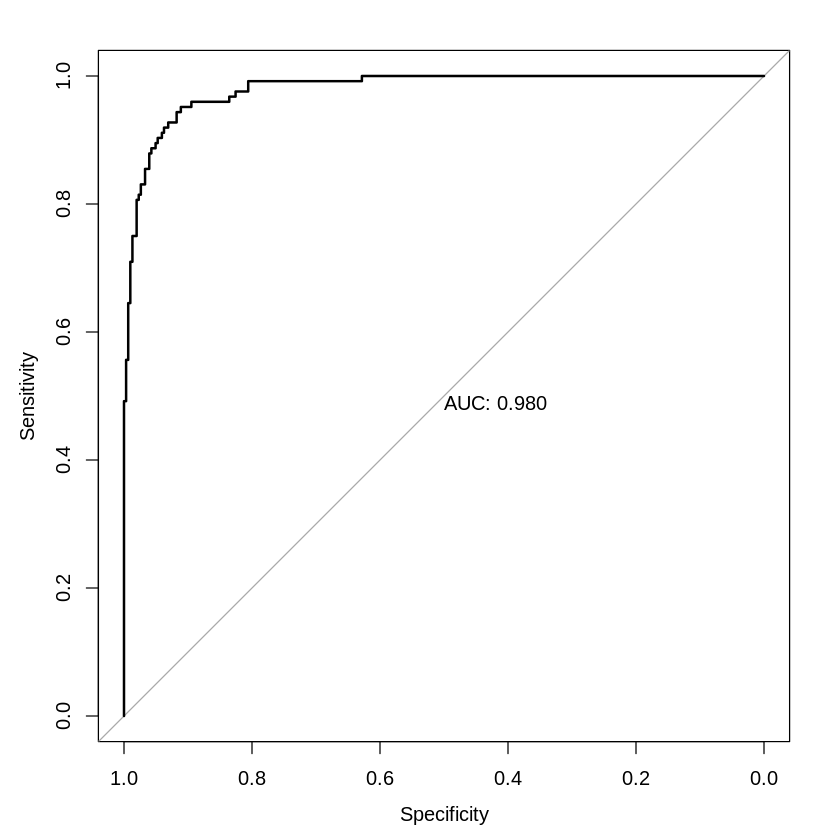

In [ ]:
model_fulldata <- glm(Cheap ~ Horsepower + Make + Type + Weight + MPG_Highway + MPG_City, data = df, family = binomial(link="logit"))
roc_glm <- pROC::roc(model_fulldata$y, model_fulldata$fitted.values)
plot(roc_glm, print.auc = TRUE)

Setting levels: control = 0, case = 1

Setting direction: controls < cases



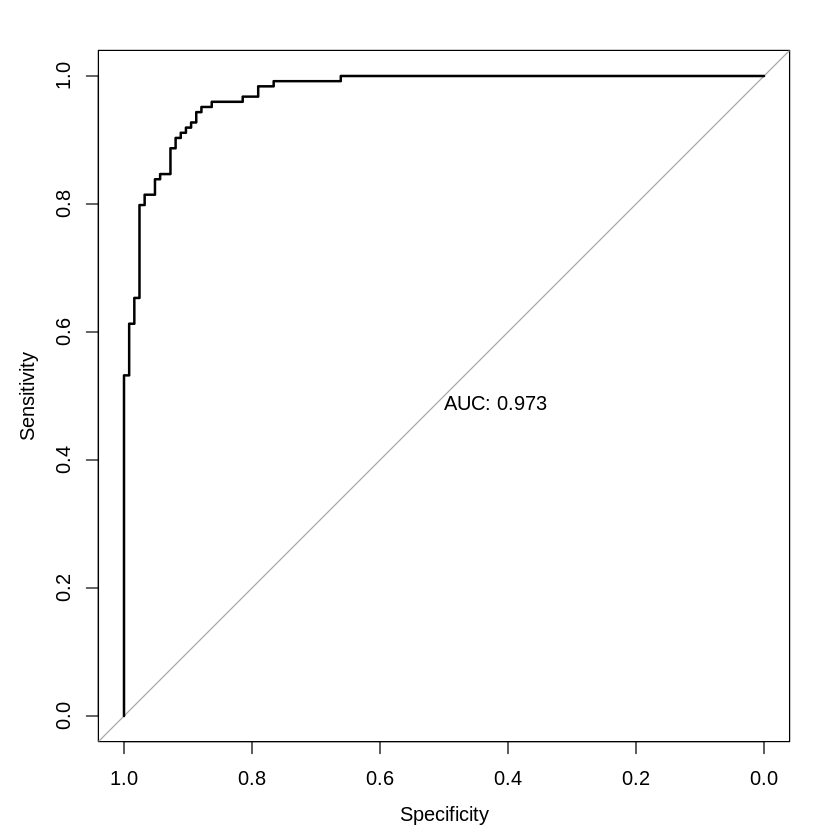

In [ ]:
model_undersampled <- glm(Cheap ~ Horsepower + Make + Type + Weight + MPG_Highway + MPG_City, data = undersampled_data, family = binomial(link="logit"))
roc_glm <- pROC::roc(model_undersampled$y, model_undersampled$fitted.values)
plot(roc_glm, print.auc = TRUE)

Качество undersampled модели изменилось несущественное (значение AUC = 0.98 для модели с полным набором данных и 0.973 для undersampled)

## Пункт 5

Waiting for profiling to be done...



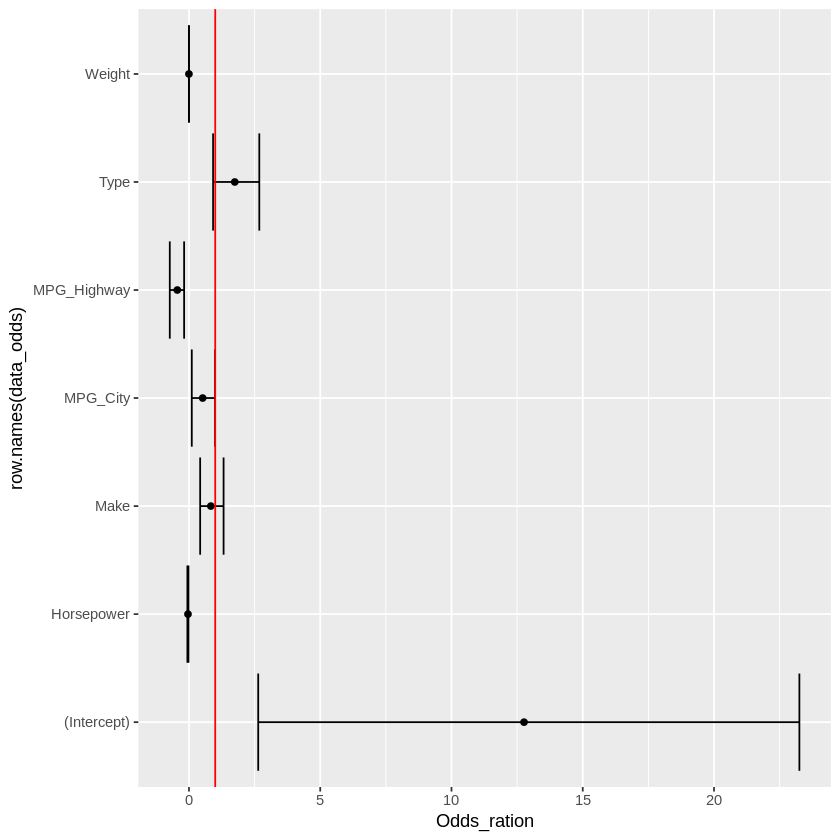

In [ ]:
data_odds <- data.frame(cbind(OR = coef(model_fulldata)))
data_odds <- suppressWarnings(cbind(data_odds, confint(model_fulldata)))
names(data_odds) <- c("Odds_ration", "Lower", "Upper")
ggplot(data_odds, aes(y = row.names(data_odds), x = Odds_ration)) +
geom_point() +
geom_errorbar(aes(xmin = Lower, xmax = Upper)) +
geom_vline(xintercept = 1.0, colour = "red")

In [ ]:
# install.packages('vcdExtra')
# install.packages('mice')
# install.packages('caret')
# install.packages('pROC')
# install.packages('AUC')
# install.packages("ROSE")
# install.packages("caret")
# install.packages("ggplot2")
# install.packages("fbroc")
# install.packages("verification")
# install.packages("Hmisc")